<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name = 'Index'> </a> <font color='orange'> Índice </font>

* [Notas iniciales](#NotasIniciales)
* Instalación del entorno
* Análisis descriptivo de los datos
* Pruebas, con input:
  * 'postText' (Texto del tweet)
    * Búsqueda de hiperparámetros en BERT
    * Búsqueda de hiperparámetros en RoBERTa
    * Búsqueda de hiperparámetros en XLN
  * 'postText' (Texto del tweet) + 'targetKeywords'
    * Búsqueda de hiperparámetros en BERT
    * Búsqueda de hiperparámetros en RoBERTa
    * Búsqueda de hiperparámetros en XLN
  * 'postText' (Texto del tweet) + 'targetParagraphs'
    * Búsqueda de hiperparámetros en Longformer
* Evaluación del dataset para cada input y checkpoint correspondiente. 
  * Comparación con estado del arte
* Análisis de errores

# <a name="NotasIniciales"> </a> <font color='orange'> Notas iniciales </font>

<font color='lightgreen'> Comentarios </font>
* # NO EJECUTAR TODAS LAS CELDAS A LA VEZ #
* Este es el **archivo principal** donde se recogen todas las pruebas. **Cada prueba** posee una **configuración de parámetros difentes**, y llaman a una **única función** que recoge el pipeline más complejo, controlando mediante flags qué funciones deben ejecutarse. Dichas funciones se encuentran todas en la carpeta Utils
* El índice contiene enlaces a cada sección para una navegación más cómoda. 

<font color='lightgreen'> Referencias </font>

Quiero remarcar dos proyectos que hacen un trabajo muy parecido y al que les he echado un vistazo. Aunque obtengo ideas de ellos, considero que no hay plagio. Dichos trabajos servirán como referencia para comparar el modelo aquí desarrollado.
* [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)


# <font color='orange'> Parámetros </font>
Por comodidad, los parámetros a ajustar se encuentran en la parte superior del cuaderno.

In [1]:
default_config = {}

# Directories
default_config['train_dir'] = '/content/ClickbaitDetector/data/webis_train.csv'
default_config['test_dir'] = '/content/ClickbaitDetector/data/webis_test.csv'

# Flags
default_config['do_descriptive_analysis'] = False
default_config['do_hyperparameter_search'] = False

# Descriptive analysis


logger_transformers = 'error'

# Dataset
train_val_split = 0.15
clip_min_mean = 0.4
clip_max_mean = 0.6

# Training
learning_rate = 1e-5
batch_size = 8
num_epochs = 1
weight_decay = 1e-5

# Hyperparameter search
n_trials = 1
#hp = {'learning_rate': [1e-6, 9e-5], # Uniform sampling between min-max
      #'weight_decay': [4e-5, 1e-2], # Uniform sampling between min-max
      #'epochs': [1,1], # Pick one between min-max
      #'batch_size_train': [8, 16, 32]} # Pick one

hp = {'learning_rate': [1e-5, 1e-5], # Uniform sampling between min-max
      'weight_decay': [1e-3, 1e-3], # Uniform sampling between min-max
      'epochs': [3,3], # Pick one between min-max
      'batch_size_train': [32]} # Pick one

# Checkpoint
checkpoint = 'bert-base-uncased'

[Volver al índice](#Index)

# <font color='orange'> Setup </font>
Clonar el proyecto, instalar e importar dependencias. Puede durar varios minutos.

In [2]:
!git clone https://github.com/Albmargar1/ClickbaitDetector -q

fatal: destination path 'ClickbaitDetector' already exists and is not an empty directory.


In [3]:
!pip install -q transformers

In [4]:
!pip install datasets -q folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

In [5]:
!pip install optuna -q

In [6]:
import sys
sys.path.append('/content/ClickbaitDetector/')

import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from datasets import load_metric
import torch
import optuna
from sklearn.model_selection import train_test_split

from utils import data_processing, descriptive_analysis

# <font color='orange'> Pipeline </font>

In [7]:
def pipeline(p):
  # Load data
  data_train = data_processing.process_file(p['train_dir'])
  data_test = data_processing.process_file(p['test_dir'])

  if p['do_descriptive_analysis']:
    descriptive_analysis.overall_info(data_train)
    descriptive_analysis.study_std(data_train)
    descriptive_analysis.probability_clickbait_per_words_clickbait(data_train)
    descriptive_analysis.given_word_check_probability_clickbait(data_train)

# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait


 

Tweets legítimos: 14777 
Tweets clickbait: 4761 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24367898454294196 





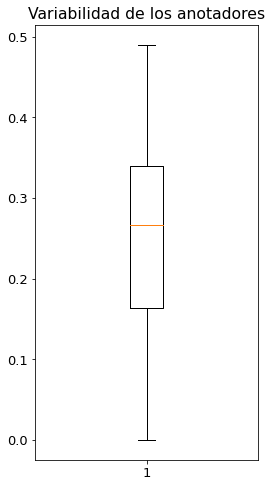

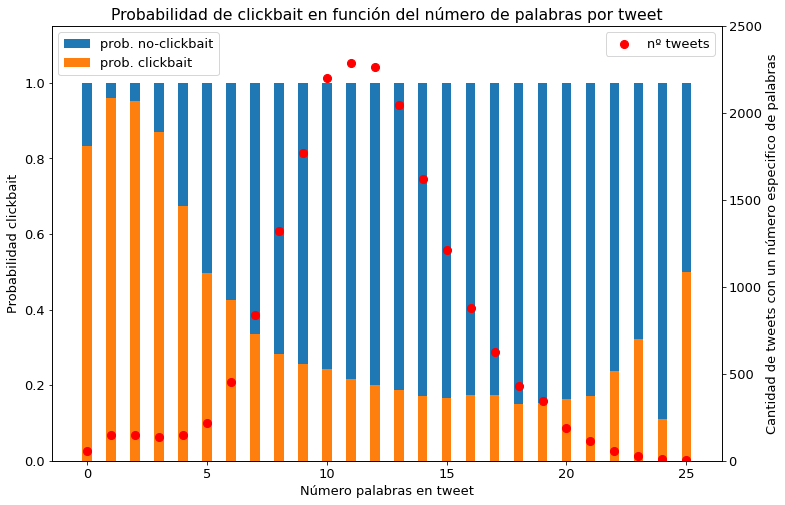

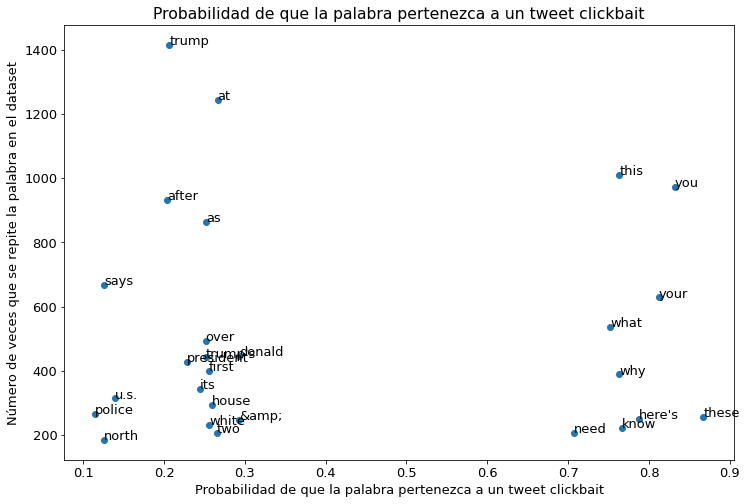

In [8]:
descriptive_config = default_config
descriptive_config['do_descriptive_analysis'] = True

pipeline(p=descriptive_config)

<font color='lightgreen'> Variabilidad de los anotadores </font>

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

La cantidad de datos a descartar se tomará como un hiperparámetro. Esto puede perjudicar en que hay un menor número de datos que entrenar, por lo que no resulta obvio que vaya a mejorar el modelo. Por lo tanto, la cantidad de datos a descartar se tomará como un hiperparámetro.

*Nota: Esta idea la he sacado de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*, donde aseguran que 



<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

<font color='lightgreen'> Probabilidad de que la palabra aparezca en un clickbait </font>

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

# <font color='orange'> Hugging Face dataset y tokenización </font>

In [432]:
data_train['truthClass'][data_train['truthClass'] == 'clickbait'] = 1
data_train['truthClass'][data_train['truthClass'] == 'no-clickbait'] = 0
data_train.rename(columns = {'truthClass':'labels'}, inplace = True)

train, val = train_test_split(data_train, test_size=train_val_split)

In [433]:
def clip_dataset_mean(dataset):
  return dataset[(dataset['truthMean']<clip_min_mean) | (dataset['truthMean']>=clip_max_mean)].reset_index(drop=True)



In [434]:
train = clip_dataset_mean(train)

In [435]:
data_dic = datasets.DatasetDict({'train': datasets.Dataset.from_pandas(train),
                                 'val': datasets.Dataset.from_pandas(val)})

In [436]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(dataset):
    return tokenizer(dataset["postText"], truncation=True)

tokenized_datasets = data_dic.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = load_metric("glue", "mrpc")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [437]:
### TO REMOVE ###

#columns_to_keep = ["attention_mask", "input_ids", "labels", "token_type_ids"]

#for d in tokenized_datasets.keys():
  #for k in tokenized_datasets[d].features:
    #if k not in columns_to_keep:
      #tokenized_datasets[d] = tokenized_datasets[d].remove_columns(k)
      

In [438]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        checkpoint, num_labels=2, return_dict=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [439]:
class Objective:
  def __init__(self):
    self.best_model = None
    self._model = None

  def __call__(self, trial: optuna.Trial):        
    learning_rate = trial.suggest_loguniform('learning_rate', 
                                            low=hp['learning_rate'][0], 
                                            high=hp['learning_rate'][1])
      
    weight_decay = trial.suggest_loguniform('weight_decay', 
                                            low=hp['weight_decay'][0], 
                                            high=hp['weight_decay'][1])
      
    epochs = trial.suggest_int('epochs', 
                              low=hp['epochs'][0], 
                              high=hp['epochs'][1])
      
    batch_size_train = trial.suggest_categorical('batch_size_train', 
                                                hp['batch_size_train'])
      
    print(bcolors.blue, '\nHiperparámetros test', trial.number,
          '\nlearning_rate:', learning_rate, 
          '\nweight_decay:', weight_decay, 
          '\nepochs:', epochs, 
          '\nbatch_size_train:', batch_size_train, 
          bcolors.endc)

    training_args = TrainingArguments(output_dir='test',
                                      learning_rate=learning_rate,         
                                      weight_decay=weight_decay,         
                                      num_train_epochs=epochs,         
                                      per_device_train_batch_size=batch_size_train, 
                                      per_device_eval_batch_size=32,
                                      save_strategy = 'no',
                                      disable_tqdm=False,
                                      log_level=logger_transformers)
                                        
    trainer = Trainer(args=training_args,
                      tokenizer=tokenizer,
                      data_collator= data_collator,
                      train_dataset=tokenized_datasets['train'],
                      eval_dataset=tokenized_datasets['val'],
                      model_init=model_init,
                      compute_metrics=compute_metrics)
                        
          
    result = trainer.train()
    self.trainer = trainer

    eval_result = trainer.evaluate()     
    print(bcolors.blue, '\n F1-score en test', trial.number,'=', eval_result['eval_f1'], '\n', bcolors.endc)

    return eval_result['eval_f1']

  def callback(self, study, trial):
    if study.best_trial == trial:
        self.best_model = self.trainer.model

In [440]:
if do_hyperparameter_search:
  objective = Objective()
  study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
  study.optimize(objective, n_trials=n_trials, callbacks=[objective.callback]) 
  objective.best_model.save_pretrained('./ClickbaitDetector/model/',checkpoint,'-clickbait/')

[I 2022-04-05 11:01:56,021] A new study created in memory with name: hyper-parameter-search


 
Hiperparámetros test 0 
learning_rate: 1e-05 
weight_decay: 0.001 
epochs: 3 
batch_size_train: 32 


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss
500,0.258200
1000,0.166600


[I 2022-04-05 11:11:45,843] Trial 0 finished with value: 0.678125 and parameters: {'learning_rate': 1e-05, 'weight_decay': 0.001, 'epochs': 3, 'batch_size_train': 32}. Best is trial 0 with value: 0.678125.


 
 F1-score en test 0 = 0.678125 
 


In [441]:
torch.cuda.empty_cache()